<a href="https://colab.research.google.com/github/hmobley/liveproject_water/blob/master/Part5_Optimizing_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Preliminaries for Colab

Like Part 3 and 4 previously, below are some convenience functions for those working on Google Colab with a GPU runtime

In [ ]:
#colab = 0
colab = 1

In [1]:
# must be a pre-written method for this!
def clear_drive():
  if (colab == 1):
    !rm -r nwpu_images
    !rm -r nwpu_label_images
    !rm -r s2cloudless_imagery
    !rm -r s2cloudless_label_imagery
    !rm nwpu_images.zip
    !rm nwpu_label_images.zip
    !rm opt_model_1_early
    !rm opt_model_1_early_hist
    !rm opt_model_2_big
    !rm opt_model_2_big_hist
    !rm opt_model_3_bn
    !rm opt_model_3_bn_hist
    !rm opt_model_4_res
    !rm opt_model_4_res_hist
    !rm opt_model_5_res_dice
    !rm opt_model_5_res_dice_hist
    !rm s2cloudless_imagery.zip
    !rm s2cloudless_label_imagery.zip
    !rm res_unet8.h5
    !rm res_dice_unet2.h5

In [2]:
clear_drive()

rm: cannot remove 'opt_model_1_early': No such file or directory
rm: cannot remove 'opt_model_1_early_hist': No such file or directory
rm: cannot remove 'opt_model_2_big': No such file or directory
rm: cannot remove 'opt_model_2_big_hist': No such file or directory
rm: cannot remove 'opt_model_3_bn': No such file or directory
rm: cannot remove 'opt_model_3_bn_hist': No such file or directory
rm: cannot remove 'opt_model_4_res': No such file or directory
rm: cannot remove 'opt_model_5_res_dice': No such file or directory
rm: cannot remove 'res_unet8.h5': No such file or directory
rm: cannot remove 'res_dice_unet2.h5': No such file or directory


In [3]:
load_res_history = 1
load_res_dice_history = 1
#load_large_history = 1
if load_res_history or load_res_dice_history:
  import pickle

In [4]:
if colab==1:
    %tensorflow_version 2.x
    !pip install --default-timeout=1000 tensorflow-gpu==2.0   

You may have to restart the runtime and/or change runtime type here, if the following doesn't show Tensorflow version 2, and a GPU available

In [5]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
False


Convenience functions if you need to download example (minimal) imagery sets derived from NWPU and Sentinel-2 cloudless:

In [6]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


#s2 cloudless imagery
file_id = '1iMfIjr_ul49Ghs2ewazjCt8HMPfhY47h'
destination = 's2cloudless_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#s2 cloudless labels
file_id = '1c7MpwKVejoUuW9F2UaF_vps8Vq2RZRfR'
destination = 's2cloudless_label_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu imagery
file_id = '1gtuqy1VlU8-M5IEMnmiSuTlI5PxQPnGB'
destination = 'nwpu_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu labels
file_id = '1W5LGbcYAcFbG5YjLgX_ekBn0u5Rno35x'
destination = 'nwpu_label_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)                        

In [7]:
import zipfile
def unzip(f):
    """
    f = file to be unzipped
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()
        
if colab==1:
    unzip('s2cloudless_imagery.zip')
    unzip('s2cloudless_label_imagery.zip')   
    unzip('nwpu_images.zip')
    unzip('nwpu_label_images.zip')       

Import the libraries we will need:

In [8]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Training tuning strategies</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
We will set up a baseline model with no optimization using the NWPU imagery, then explore the following training optimization strategies:
<ul>
  <li>Building a bigger model with more layers</li>    
  <li>Using Early Stopping and Adaptive Learning Rates</li> 
  <li>Using a bigger model (and dropout)</li> 
  <li>Using regularization (Batch Normalization)</li> 
  <li>Using residual connections</li> 
</ul>
</p>
        </tr>
        </table>

#### Getting things set up with a baseline model
Zip through all these functions that we defined in the last Part. 

Like in the last Part, we will define the ```unet``` model, create model training callbacks, and generate augmented imagery

In [9]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

def unet(sz = (512, 512, 3)):
  inputs = Input(sz)
  _ = inputs
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    layers.append(_)
    _ = MaxPooling2D() (_)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
  _ = Concatenate(axis=3)([_, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
    _ = Concatenate(axis=3)([_, layers[j]])
    j = j -1 
    
  #classification 
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  outputs = Conv2D(1, 1, activation='sigmoid') (_)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model 

model = unet()      

In [10]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        infile = f'nwpu_images/data/{path}'
        raw = Image.open(infile)
        raw = np.array(raw.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))
                
        #mask post-processing 
        msk  = (pred>60).astype('int') #100       
        msk = np.stack((msk,)*3, axis=-1)
        #msk[msk >= 0.5] = 1 
        #msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()      

We use Keras callbacks to implement learning rate decay if the validation loss does not improve for 5 continues epochs. Called "reduce loss on plateau"

Also, we implement early stopping if the validation loss does not improve for 5 continuous epochs.

In [11]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f'nwpu_images/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('nwpu_images','nwpu_label_images')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>200).astype('int')
        
        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

We've seen code like the below in the previous Part, setting up batch size, proportion of the dataset to train with, getting randomized lists of test and train file names, and finally setting up generators for model training and testing

In [12]:
batch_size = 8

prop_train = 0.6

all_files = os.listdir('nwpu_images/data')
shuffle(all_files)

split = int(prop_train * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)

A customary check that things worked

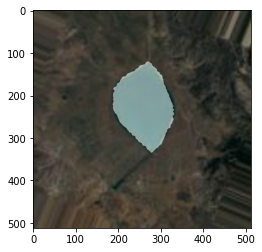

In [13]:
x, y = next(train_generator)
plt.imshow(x[0])
plt.imshow(y[0].squeeze(), cmap='gray', alpha=0.5)

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Optimization strategy: Using Early Stopping<br/>and Adaptive Learning Rates</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
    Neural networks can overfit if they train for too long, but it's hard to know how many epochs is too many without a lot of trial and error, which is not efficient. Automatically computing how many training epochs a model needs or, to put it another way, evaluating when to stop training or <em>early stopping</em>, is achieved by monitoring validation loss during training. If loss doesn't improve for a certain number of epochs, called the <em>patience</em>, model training is terminated. Below <em>patience</em> is set to 5. Another common training strategy to prevent overly long training times is to adaptively change the learning rate during model training. This is achieved by starting with a relatively large number and then decreasing it after every training epoch until a specified minimum <em>min_lr</em> at a certain rate of reduction <em>min_delta</em>.</p>
        </tr>
        </table>

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [15]:
def build_callbacks(filepath, min_delta, min_lr, factor):

    earlystop = EarlyStopping(monitor="val_loss", 
                                  mode="min", patience=5) 
    
    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=5, 
                                    verbose=1, mode='auto', min_delta=min_delta, 
                                    cooldown=5, min_lr=min_lr)

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    callbacks = [model_checkpoint, reduceloss_plat, earlystop, PlotLearning()]

    return callbacks  

In [16]:
# a tolerance for the training.
min_delta = 0.0001

# minimum learning rate (lambda)
min_lr = 0.0001

# the factor applied to the learning rate when the appropriate triggers are made
factor = 0.8

batch_size = 8

filepath = 'unet'+str(batch_size)+'.h5'

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Optimization strategy: changing model architecture <br/>using residual connections</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
A standard approach is to pass the input image goes through multiple convolutions and obtain high-level features. In a network architecture with <em>residual layers</em> or connections, each layer gets to see both the output from the previous layer (standard) as well as the inputs to that layer. So it not only sees the ouputs but also the data used to learn that output
</p>
        </tr>
        </table>

![](https://cdn-images-1.medium.com/max/1000/1*4wx7szWCBse9-7eemGQJSw.png)

Import `Activation` and `Add` layers from keras

In [17]:
from tensorflow.keras.layers import Activation, Add
from tensorflow.keras.layers import BatchNormalization

Create a new UNet model function. This time we'll use a few convenience functions

In [18]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [19]:
model = res_unet((512, 512, 3), 16)
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 512, 512, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 512, 512, 16) 64          input_2[0][0]                    
____________________________________________________________________________________________

Train the model with the residual connections:

In [20]:
batch_size = 2

filepath = 'res_unet'+str(batch_size)+'.h5'

train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

171
114


In [21]:
if load_res_history:
  file_id = '1ht_dICAOsp8tDX0osyn1xd_ViGAMealY'
  destination = 'opt_model_4_res_hist'
  download_file_from_google_drive(file_id, destination)
  with open("opt_model_4_res_hist", "rb") as file_pi:
    res_history = pickle.load(file_pi)
else:
    res_history = model.fit_generator(train_generator, 
                                      epochs = 100, steps_per_epoch = train_steps,
                                      validation_data = test_generator, 
                                      validation_steps = test_steps,
                                      callbacks = build_callbacks(filepath, min_delta, 
                                                                  min_lr, factor), 
                                      verbose = 0,
                                      use_multiprocessing=True)

In [22]:
if not load_res_history:
  #save model and history to load or graph later
  model.save("opt_model_4_res",save_format="h5")
  
  with open('opt_model_4_res_hist', 'wb') as file_pi:
    pickle.dump(res_history.history, file_pi)# save model and history to load or graph later
  
  del model

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Optimization strategy: Dealing with class imbalance <br/> using dice loss</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
    the network tends to <b>ignore smaller classes</b>. A soft dice loss could be used to train a model. Unlike the IoU metric, the numerator is the number of correctly classified pixels, and the denominator is the total number of pixels in a class that is in both estimated and ground truth. Thus it is insensitive to the number of pixels total in each class.  
        </tr>
        </table>

In [23]:
from tensorflow.keras.layers import Flatten

In [24]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [25]:
model = res_unet((512, 512, 3), 32)
model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 512, 512, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 512, 512, 32) 128         conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 512, 512, 32) 128         input_3[0][0]                    
____________________________________________________________________________________________

Before we start training we need to update out `PlotLearning` class with the new loss metric

In [26]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'dice_coef=',logs.get('dice_coef'),'val_dice_coef=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        infile = f'nwpu_images/data/{path}'
        raw = Image.open(infile)
        raw = np.array(raw.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))
                
        #mask post-processing 
        msk  = (pred>60).astype('int') #100       
        msk = np.stack((msk,)*3, axis=-1)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()      

Train the Residual-UNet model again, this time with dice loss

In [27]:
batch_size = 2

filepath = 'res_dice_unet'+str(batch_size)+'.h5'

train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

171
114


In [28]:
if load_res_dice_history:
  file_id = '1cqmkrD7P3DNvNgAMbk5gqJT68UCnw1k8'
  destination = 'opt_model_5_res_dice_hist'
  download_file_from_google_drive(file_id, destination)
  with open("opt_model_5_res_dice_hist", "rb") as file_pi:
    res_dice_history = pickle.load(file_pi)
else:
    res_dice_history = model.fit_generator(train_generator, 
                    epochs = 100, steps_per_epoch = train_steps,
                    validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(filepath, min_delta, min_lr, factor), 
                    verbose = 0,
                    use_multiprocessing=True)

In [29]:
if not load_res_dice_history:
  #save model and history to load or graph later
  model.save("opt_model_5_res_dice",save_format="h5")
  
  with open('opt_model_5_res_dice_hist', 'wb') as file_pi:
    pickle.dump(res_dice_history.history, file_pi)# save model and history to load or graph later
  
  del model

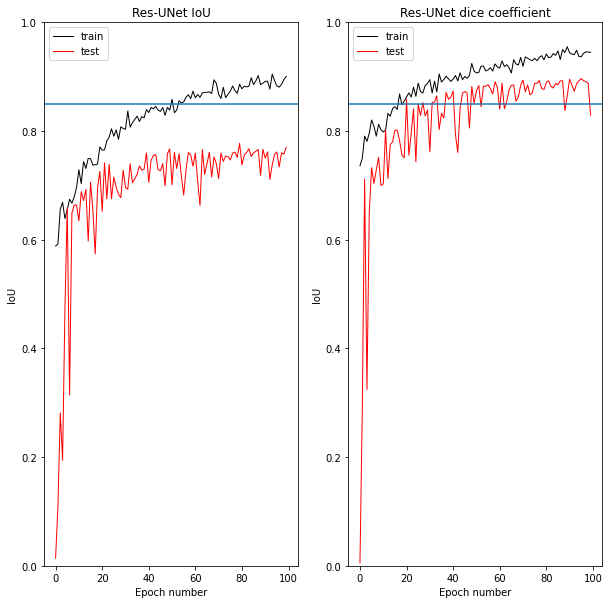

In [30]:
# summarize history for iou
plt.figure(figsize=(10,10))
plt.subplot(121)
if load_res_history:
    plt.plot(res_history['mean_iou'],'k',lw=1)
    plt.plot(res_history['val_mean_iou'],'r',lw=1)
else:
    plt.plot(res_history.history['mean_iou'],'k',lw=1)
    plt.plot(res_history.history['val_mean_iou'],'r',lw=1)    
plt.ylim(0,1)
plt.axhline(y=0.85)
plt.title('Res-UNet IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
if load_res_dice_history:
    plt.plot(res_dice_history['dice_coef'],'k',lw=1)
    plt.plot(res_dice_history['val_dice_coef'],'r',lw=1)
else:
    plt.plot(res_dice_history.history['dice_coef'],'k',lw=1)
    plt.plot(res_dice_history.history['val_dice_coef'],'r',lw=1)    
plt.ylim(0,1)
plt.axhline(y=0.85)
plt.title('Res-UNet dice coefficient')
plt.ylabel('IoU')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

plt.show()